In [1]:
import torch
import torchvision
from torch import nn
from torch.utils import data
from d2l import torch as d2l
import math

__all__ = ['mobilenext']


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class SandGlass(nn.Module):
    def __init__(self, inp, oup, stride, reduction_ratio):
        super(SandGlass, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp // reduction_ratio)
        self.identity = stride == 1 and inp == oup

        self.conv = nn.Sequential(
            # dw
            nn.Conv2d(inp, inp, 3, 1, 1, groups=inp, bias=False),
            nn.BatchNorm2d(inp),
            nn.ReLU6(inplace=True),
            # pw-linear
            nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
            nn.BatchNorm2d(hidden_dim),
            # pw
            nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
            nn.BatchNorm2d(oup),
            nn.ReLU6(inplace=True),
            # dw-linear
            nn.Conv2d(oup, oup, 3, stride, 1, groups=oup, bias=False),
            nn.BatchNorm2d(oup),
        )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNeXt(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.):
        super(MobileNeXt, self).__init__()
        # setting of sandglass blocks
        self.cfgs = [
            # t, c, n, s
            [2, 96, 1, 2],
            [6, 144, 1, 1],
            [6, 192, 3, 2],
            [6, 288, 3, 2],
            [6, 384, 4, 1],
            [6, 576, 4, 2],
            [6, 960, 3, 1],
            [6, 1280, 1, 1],
        ]

        # building first layer
        input_channel = _make_divisible(32 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = SandGlass
        for t, c, n, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            for i in range(n):
                layers.append(block(input_channel, output_channel, s if i == 0 else 1, t))
                input_channel = output_channel
        self.features = nn.Sequential(*layers)
        # building last several layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(output_channel, num_classes)
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenext(**kwargs):
    """
    Constructs a MobileNeXt model
    """
    return MobileNeXt(**kwargs)

In [2]:
def load_data_cifar100(batch_size=128):
    transform_train = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.Resize(40),
        torchvision.transforms.RandomResizedCrop(32, scale=(0.64, 1.0),
                                                 ratio=(1.0, 1.0)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                         [0.2023, 0.1994, 0.2010])])

    transform_test = torchvision.transforms.Compose([
        # torchvision.transforms.Resize(256),
        # torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465],
                                         [0.2023, 0.1994, 0.2010])])

    trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                             download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=0)

    testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                            download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=0)
    return trainloader, testloader


def train_batch(net, X, y, loss, trainer, devices):
    X = X.to(devices)
    y = y.to(devices)
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum


def train(net, train_iter, valid_iter, num_epochs, loss, trainer, lr_period,
          lr_decay, use_sl=True, device=d2l.try_gpu()):
    if use_sl:
        scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = net.to(device)
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(net, features, labels, loss,
                                 trainer, device)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(
                    epoch + (i + 1) / num_batches,
                    (metric[0] / metric[2], metric[1] / metric[2], None))
        if valid_iter is not None:
            valid_acc = evaluate_accuracy(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        if use_sl:
            scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
                     f' examples/sec')


def evaluate_accuracy(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]


def train_fine_tuning(net, learning_rate, lr_period, lr_decay, train_iter, valid_iter, loss, num_epochs=5,
                      param_group=True):
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
                     if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                  lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.001)
    train(net, train_iter, valid_iter, num_epochs, loss, trainer, lr_period, lr_decay)

train loss 0.774, train acc 0.767, valid acc 0.368
393.9 examples/sec


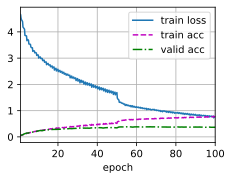

In [3]:
net = mobilenext(num_classes=100)
devices = d2l.try_gpu()
num_epochs = 100
lr = 2e-4
wd = 5e-4
lr_period = 50
lr_decay = 0.1
trainloader, validloader = load_data_cifar100()
loss = nn.CrossEntropyLoss(reduction="none")
trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
train(net, trainloader, validloader, num_epochs, loss, trainer, lr_period, lr_decay)
torch.save(net.state_dict(), "mobilenext.pth", _use_new_zipfile_serialization=True)